In [14]:
from lib.utilities import *
import matplotlib.pyplot as plt

%matplotlib widget

In [15]:
datadir = "./tsm_targets/02-07-22" # All files in this directory + subdirectories are loaded
#datadir = "./tsm_targets" # All files in this directory + subdirectories are loaded
#datadir = "C:/Turbo-SM/SMDATA/Untitled"
#datadir = "C:/Turbo-SM/SMDATA/John/01-17-22"
selected_filename = "Untitled006" # focus for subsequent analysis
#selected_filename = "OMP25-Cerulean3-cell4003"
file_type = '.tsm'

# IMPORTANT! Must make the final image SQUARE for PhotoZ to manage properly
horizontal_cropping = [450, 550]  # This is the cropping recommended for 1024x100-px width
horizontal_cropping = [352, 672]  # This is the cropping recommended for 1024x320-px width

t_cropping = [0, -1]  # TSM artifacts
binning = 5

In [16]:
# Load data
processed = [] # to avoid re-processing later
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir, file_only=selected_filename)
    
print(data_loader.get_n_files_loaded(), "files loaded.")

Untitled004.tbn
Untitled004.tsm
Untitled005.tbn
Untitled005.tsm
Untitled006.tbn
Untitled006.tsm
./tsm_targets/Untitled006.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
1 files loaded.


In [17]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# If PhotoZ cannot manage the image size, increase binning and cropping
selected_data.clip_data(y_range=horizontal_cropping, t_range=t_cropping)
selected_data.bin_data(binning=binning)

raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()
fp_data = selected_data.fp_data

{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -80, 'interval_between_samples': 1.0, 'number_of_trials': 1} (1, 199, 319, 320)


(1, 199, 64, 64)


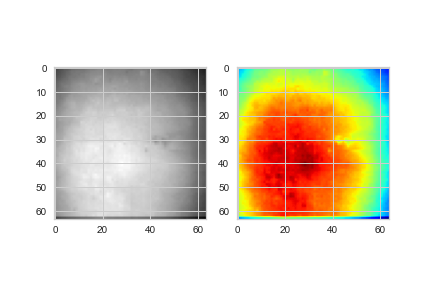

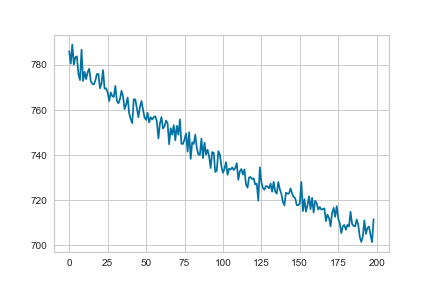

In [18]:
# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='gray')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

rli_high_cp = np.copy(raw_data[0,0,:,:]).astype(np.uint16)
plt.subplots()
plt.plot(raw_data[0,:,0,0])

if raw_data.shape[2] != raw_data.shape[3]:
    raise Exception("PhotoZ will not work with non-square array! Adjust cropping and/or binning")

In [19]:
# Fill in missing metadata
meta['version'] = 5
meta['slice_number'] = 5
meta['location_number'] = 5
meta['record_number'] = 5
meta['camera_program'] = 2

meta['interval_between_trials'] = 1
meta['acquisition_gain'] = 1
meta['time_RecControl'] = 5

meta['reset_onset'] = 1
meta['reset_duration'] = 5
meta['shutter_onset'] = 5
meta['shutter_duration'] = 5

meta['stimulation1_onset'] = 20
meta['stimulation1_duration'] = 1
meta['stimulation2_onset'] = 0
meta['stimulation2_duration'] = 0

meta['acquisition_onset'] = 1
meta['interval_between_samples'] = 5

meta['raw_width'] = raw_data.shape[2]
meta['raw_height'] = raw_data.shape[3]
meta['points_per_trace'] = raw_data.shape[1]
meta['number_of_trials'] = raw_data.shape[0]
meta['num_fp_pts'] = 8
num_diodes = int(meta['raw_width'] * meta['raw_height'] + meta['num_fp_pts'])
rli = {}
rli['rli_low'] = np.zeros((num_diodes), dtype = np.uint16)
rli['rli_high'] = np.zeros((num_diodes), dtype = np.uint16) 
rli['rli_high'][:meta['raw_width'] * meta['raw_height']] = rli_high_cp.reshape(-1)

# test 
#rli['rli_high'][:167] = 0

rli['rli_max'] = np.ones((num_diodes), dtype = np.uint16)

print(num_diodes, [rli[r].shape for r in rli])

4104 [(4104,), (4104,), (4104,)]


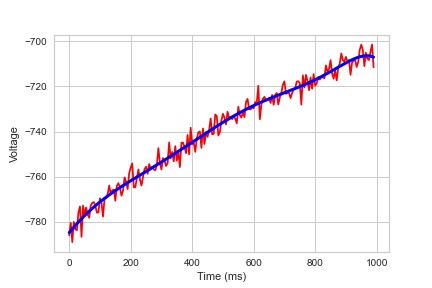

In [20]:
# Run this cell at most once

# Apply baseline correction here. Because PhotoZ chokes on baseline correcting TurboSM data
tr = Tracer()
#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)

(1, 199, 64, 64) [[[[1900 2509 2720 ... 1946 1754 1942]
   [1937 1839 1338 ... 1715 1296 1846]
   [2126 1540 2110 ... 1705 1777 1777]
   ...
   [2373 2067 1518 ... 1595 2040 2024]
   [1424 2035 1806 ... 2059 2189 1800]
   [1602 2043 2122 ... 1961 1704 1784]]

  [[2530 1663 1535 ... 2076 1845 2323]
   [2699 1806 1922 ... 2137 2743 2305]
   [1740 2702 1781 ... 2127 2308 1840]
   ...
   [1552 1759 2152 ... 2078 2190 1825]
   [1995 2023 1650 ... 1719 2188 2546]
   [2379 2017 2497 ... 2205 2612 2198]]

  [[1270 2239 1751 ... 2462 2047 1430]
   [1163 1801 2142 ... 2033 2152 1730]
   [2055 1818 2123 ... 2340 2199 2549]
   ...
   [2623 2300 2832 ... 2122 1637 2187]
   [2795 1829 1716 ... 2012 1988 2062]
   [2029 2381 1253 ... 1841 1923 1814]]

  ...

  [[2317 2485 1967 ... 1578 2384 2199]
   [1683 1960 1913 ... 1768 2355 2663]
   [2557 2111 1851 ... 2537 2149 2126]
   ...
   [2249 3034 1903 ... 2428 2390 2102]
   [2346 2504 1494 ... 1982 1852 2326]
   [2457 2267 2221 ... 1892 2061 2033]]

  [[

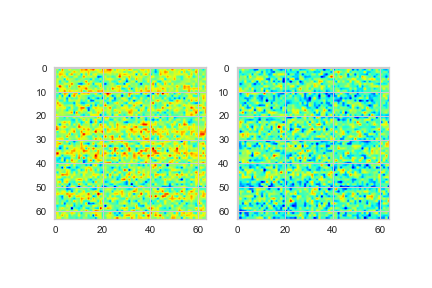

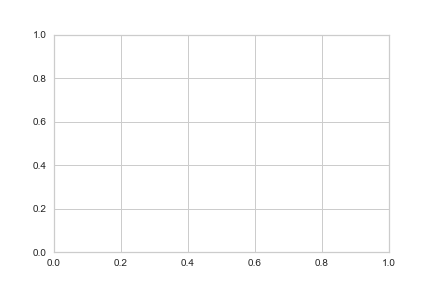

In [21]:
plt.subplots() # finalize plot from previous cell
# normalize raw data to 12-bit range
def normalize_bit_range(raw_data, bits=12):
    raw_data = raw_data.astype(np.float64)
    raw_data -= np.min(raw_data)
    raw_data /= np.max(raw_data)
    raw_data *= (2 ** bits)

    return raw_data.astype(np.uint16)

fp_data = normalize_bit_range(fp_data)
raw_data = normalize_bit_range(raw_data)
print(raw_data.shape, raw_data)

# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()


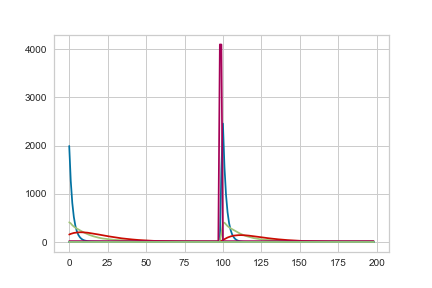

In [22]:
# resize FP data
fp_data_final = np.zeros((fp_data.shape[0], meta['num_fp_pts']))
fp_data_final[:, :fp_data.shape[1]] = fp_data[:, :]
fp_data = np.swapaxes(fp_data_final, 1, 0)

fig, ax = plt.subplots()
ax.plot(fp_data_final[t_cropping[0]:t_cropping[1], :])

In [23]:
# Write data
print(raw_data, raw_data.shape)
zda_writer = ZDA_Writer()
zda_writer.write_zda_to_file(raw_data, meta, selected_filename + ".zda", rli, fp_data[:, t_cropping[0]:t_cropping[1]])


[[[[1900 2509 2720 ... 1946 1754 1942]
   [1937 1839 1338 ... 1715 1296 1846]
   [2126 1540 2110 ... 1705 1777 1777]
   ...
   [2373 2067 1518 ... 1595 2040 2024]
   [1424 2035 1806 ... 2059 2189 1800]
   [1602 2043 2122 ... 1961 1704 1784]]

  [[2530 1663 1535 ... 2076 1845 2323]
   [2699 1806 1922 ... 2137 2743 2305]
   [1740 2702 1781 ... 2127 2308 1840]
   ...
   [1552 1759 2152 ... 2078 2190 1825]
   [1995 2023 1650 ... 1719 2188 2546]
   [2379 2017 2497 ... 2205 2612 2198]]

  [[1270 2239 1751 ... 2462 2047 1430]
   [1163 1801 2142 ... 2033 2152 1730]
   [2055 1818 2123 ... 2340 2199 2549]
   ...
   [2623 2300 2832 ... 2122 1637 2187]
   [2795 1829 1716 ... 2012 1988 2062]
   [2029 2381 1253 ... 1841 1923 1814]]

  ...

  [[2317 2485 1967 ... 1578 2384 2199]
   [1683 1960 1913 ... 1768 2355 2663]
   [2557 2111 1851 ... 2537 2149 2126]
   ...
   [2249 3034 1903 ... 2428 2390 2102]
   [2346 2504 1494 ... 1982 1852 2326]
   [2457 2267 2221 ... 1892 2061 2033]]

  [[2777 2083 2460 ..